# Textgeneration with RNNs

Actually, there is a phantastic [blob post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) about "The Unreasonable Effectiveness of Recurrent Neural Networks". He is pointing to some code to generate some charakter elvel language-models.

I believe the code is coming from there.


In [1]:
#implemented as I read Andrej Karpathy's post on RNNs.
import numpy as np
import matplotlib.pyplot as plt

class RNN(object):

    def __init__(self, insize, outsize, hidsize, learning_rate):        
        self.insize = insize

        self.h = np.zeros((hidsize , 1))#a [h x 1] hidden state stored from last batch of inputs

        #parameters
        self.W_hh = np.random.randn(hidsize, hidsize)*0.01#[h x h]
        self.W_xh = np.random.randn(hidsize, insize)*0.01#[h x x]
        self.W_hy = np.random.randn(outsize, hidsize)*0.01#[y x h]
        self.b_h = np.zeros((hidsize, 1))#biases
        self.b_y = np.zeros((outsize, 1))

        #the Adagrad gradient update relies upon having a memory of the sum of squares of dparams
        self.adaW_hh = np.zeros((hidsize, hidsize))
        self.adaW_xh = np.zeros((hidsize, insize))
        self.adaW_hy = np.zeros((outsize, hidsize))
        self.adab_h = np.zeros((hidsize, 1))
        self.adab_y = np.zeros((outsize, 1))

        self.learning_rate = learning_rate

    #give the RNN a sequence of inputs and outputs (seq_length long), and use
    #them to adjust the internal state
    def train(self, x, y):
        #=====initialize=====
        xhat = {}#holds 1-of-k representations of x
        yhat = {}#holds 1-of-k representations of predicted y (unnormalized log probs)
        p = {}#the normalized probabilities of each output through time
        h = {}#holds state vectors through time
        h[-1] = np.copy(self.h)#we will need to access the previous state to calculate the current state

        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)
        dh_next = np.zeros_like(self.h)

        #=====forward pass=====
        loss = 0
        for t in range(len(x)):
            xhat[t] = np.zeros((self.insize, 1))
            xhat[t][x[t]] = 1#xhat[t] = 1-of-k representation of x[t]

            h[t] = np.tanh(np.dot(self.W_xh, xhat[t]) + np.dot(self.W_hh, h[t-1]) + self.b_h)#find new hidden state
            yhat[t] = np.dot(self.W_hy, h[t]) + self.b_y#find unnormalized log probabilities for next chars

            p[t] = np.exp(yhat[t]) / np.sum(np.exp(yhat[t]))#find probabilities for next chars

            loss += -np.log(p[t][y[t],0])#softmax (cross-entropy loss)

        #=====backward pass: compute gradients going backwards=====
        for t in reversed(range(len(x))):
            #backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dy = np.copy(p[t])
            dy[y[t]] -= 1

            #find updates for y
            dW_hy += np.dot(dy, h[t].T)
            db_y += dy

            #backprop into h and through tanh nonlinearity
            dh = np.dot(self.W_hy.T, dy) + dh_next
            dh_raw = (1 - h[t]**2) * dh

            #find updates for h
            dW_xh += np.dot(dh_raw, xhat[t].T)
            dW_hh += np.dot(dh_raw, h[t-1].T)
            db_h += dh_raw

            #save dh_next for subsequent iteration
            dh_next = np.dot(self.W_hh.T, dh_raw)

        for dparam in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(dparam, -5, 5, out=dparam)#clip to mitigate exploding gradients

        #update RNN parameters according to Adagrad
        for param, dparam, adaparam in zip([self.W_hh, self.W_xh, self.W_hy, self.b_h, self.b_y], \
                                [dW_hh, dW_xh, dW_hy, db_h, db_y], \
                                [self.adaW_hh, self.adaW_xh, self.adaW_hy, self.adab_h, self.adab_y]):
            adaparam += dparam*dparam
            param += -self.learning_rate*dparam/np.sqrt(adaparam+1e-8)

        self.h = h[len(x)-1]

        return loss

    #let the RNN generate text
    def sample(self, seed, n):
        ndxs = []
        h = self.h

        xhat = np.zeros((self.insize, 1))
        xhat[seed] = 1#transform to 1-of-k

        for t in range(n):
            h = np.tanh(np.dot(self.W_xh, xhat) + np.dot(self.W_hh, h) + self.b_h)#update the state
            y = np.dot(self.W_hy, h) + self.b_y
            p = np.exp(y) / np.sum(np.exp(y))
            ndx = np.random.choice(range(self.insize), p=p.ravel())

            xhat = np.zeros((self.insize, 1))
            xhat[ndx] = 1

            ndxs.append(ndx)

        return ndxs




## Testing

For testing purposes I have downloaded some text of a Sonnet written by Shakespeare which was available as TXT.

data has 96158 characters, 67 unique.
ocyT oKnhn#0 izcP?y
yv.rqkb!u1H1vgjzY:?weEEHCqS,OeDIPR[U
praKLd-Tx?dW?bM'FTGKpFb]y)-Af!FzhsnmNboLJNh(G!qki,I!slMxkLJxHeYVL!bt0)PJjrHi#UJhoc(W-J0H
 cfRe#mPVRKc,Wyqu,GB0euP'b;[V
T?HD
NB[FyeGkJJ;GnXDJ)lw
iteration 0, smooth_loss = 105.117310
en ly le, fhe,

leom ar lr at t de, deu shltheaeon, pls aatest mo lene,,

Win bn nle,
S tlge focerdo thot reth dore, ththort, tham berot sm tans,
Xlts tind sen ore tet movey wan t'as alatht,
Thead tha
iteration 1000, smooth_loss = 83.873229
ngnts par or anis land r;XXM hert so torrlry IIX
Thoud soy,
Tacit chob derermun tive eime,
Fyarg nlime core duvaan me my spadive hod  ve mt that  poupeare py'im brerviigusee,
Eemy la-l Un;I
The ave be
iteration 2000, smooth_loss = 69.196222
 atk wafn hisUnd and shely haaloprnsty donind I gare;
And bose dyuucigbut theuse thyer,

C'o vin tethawl
daver, gry theet of ben toy danges.
Anly
hsurattnof pou bueto hil buat terey or yac oncrind, wh
iteration 3000, smooth_loss = 62.172310


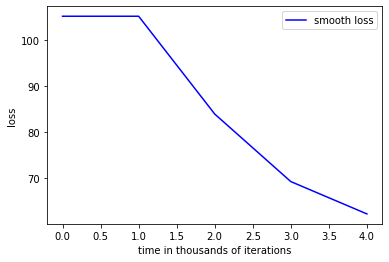

In [2]:
#open a text file
data = open('04_input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))

#make some dictionaries for encoding and decoding from 1-of-k
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

#insize and outsize are len(chars). hidsize is 100. seq_length is 25. learning_rate is 0.1.
rnn = RNN(len(chars), len(chars), 100, 0.1)

#iterate over batches of input and target output
seq_length = 25
losses = []
smooth_loss = -np.log(1.0/len(chars))*seq_length#loss at iteration 0
losses.append(smooth_loss)

for i in range(int(len(data)/seq_length)):
    x = [char_to_ix[c] for c in data[i*seq_length:(i+1)*seq_length]]#inputs to the RNN
    y = [char_to_ix[c] for c in data[i*seq_length+1:(i+1)*seq_length+1]]#the targets it should be outputting

    if i%1000==0:
        sample_ix = rnn.sample(x[0], 200)
        txt = ''.join([ix_to_char[n] for n in sample_ix])
        print(txt)

    loss = rnn.train(x, y)
    smooth_loss = smooth_loss*0.999 + loss*0.001

    if i%1000==0:
        print('iteration %d, smooth_loss = %f' % (i, smooth_loss))
        losses.append(smooth_loss)

plt.plot(range(len(losses)), losses, 'b', label='smooth loss')
plt.xlabel('time in thousands of iterations')
plt.ylabel('loss')
plt.legend()
plt.show()